In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karthik0908","key":"cb33ecc424b9eb11652e5e2b5f4bed16"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s CelebFaces

ref                           title                                   size  lastUpdated          downloadCount  
----------------------------  --------------------------------------  ----  -------------------  -------------  
jessicali9530/celeba-dataset  CelebFaces Attributes (CelebA) Dataset   1GB  2018-06-01 20:08:48          22847  


In [5]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d jessicali9530/celeba-dataset   

 99% 1.31G/1.33G [00:16<00:00, 70.7MB/s]
100% 1.33G/1.33G [00:16<00:00, 86.4MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [0]:
import pandas as pd

In [0]:
df=pd.read_csv('/content/list_attr_celeba.csv')

In [0]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [0]:
import torch
import torchvision
import numpy as np
from torchvision import transforms,datasets
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import sampler
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def get_dataloader(batch_size, image_size, data_dir='/content/img_align_celeba/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size:cele The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
  
    dataset = datasets.ImageFolder(data_dir,transform = transform)
    
    dataloader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)
    return dataloader
# Define function hyperparameters
batch_size = 256
img_size = 32
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

In [29]:
print(len(celeba_train_loader))

792


torch.Size([256, 3, 32, 32])


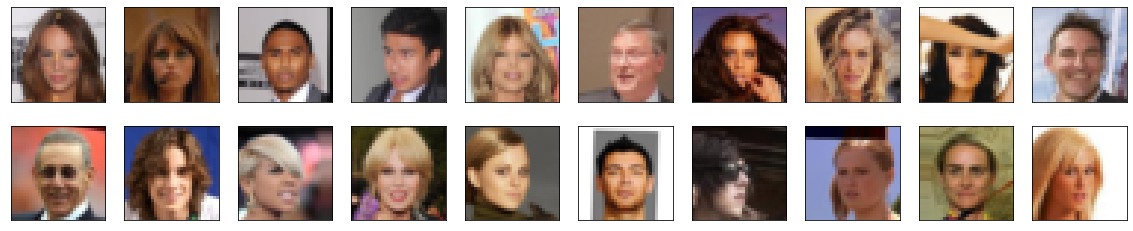

In [39]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# obtain one batch of training images
images, _ = next(iter(celeba_train_loader)) # _ for no labels
print(images.shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [0]:
###############################################################################
###############################################################################
#                   DISCRIMINATOR       NETWORK                               #
###############################################################################
###############################################################################


def conv(input_c,output,kernel_size,stride = 2,padding  = 1, batch_norm = True):
    layers =[]
    con = nn.Conv2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(con)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    
    return nn.Sequential(*layers)
class Discriminator(nn.Module):
  def __init__(self, conv_dim):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim
    self.layer_1 = conv(3,conv_dim,4,batch_norm = False) #16
    self.layer_2 = conv(conv_dim,conv_dim*2,4) #8
    self.layer_3 = conv(conv_dim*2,conv_dim*4,4) #4
    self.fc = nn.Linear(conv_dim*4*4*4,1)
  def forward(self, x):
    x = F.leaky_relu(self.layer_1(x))
    x = F.leaky_relu(self.layer_2(x))
    x = F.leaky_relu(self.layer_3(x))
    x = x.view(-1,self.conv_dim*4*4*4)
    x = self.fc(x)
    return x

In [0]:
###############################################################################
###############################################################################
#                       GENERATOR      NETWORK                                #
###############################################################################
###############################################################################




def deconv(input_c,output,kernel_size,stride = 2, padding =1, batch_norm = True):
    layers = []
    decon = nn.ConvTranspose2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(decon)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    return nn.Sequential(*layers)
class Generator(nn.Module):
  def __init__(self, z_size, conv_dim):
    super(Generator, self).__init__()
    # complete init function
    self.conv_dim = conv_dim
    self.fc = nn.Linear(z_size,conv_dim*8*2*2)
    self.layer_1 = deconv(conv_dim*8,conv_dim*4,4) #4
    self.layer_2 = deconv(conv_dim*4,conv_dim*2,4) #8
    self.layer_3 = deconv(conv_dim*2,conv_dim,4) #16
    self.layer_4 = deconv(conv_dim,3,4,batch_norm = False) #32
        
        
  def forward(self, x):
    x = self.fc(x)
    x = x.view(-1,self.conv_dim*8,2,2) #(batch_size,depth,width,height)
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = F.relu(self.layer_3(x))
    x = torch.tanh(self.layer_4(x))
    return x

In [0]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if hasattr(m,'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
    m.weight.data.normal_(0.0,0.02)
  if hasattr(m,'bias') and m.bias is not None:
    m.bias.data.zero_()

In [14]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
  D = Discriminator(d_conv_dim)
  G = Generator(z_size=z_size, conv_dim=g_conv_dim)
# initialize model weights
  D.apply(weights_init_normal)
  G.apply(weights_init_normal)
  print(D)
  print()
  print(G)
  return D, G
   
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (layer_1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding

In [0]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss
def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =  nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [0]:
d_optimizer = optim.Adam(D.parameters(),lr = .0002, betas = [0.5,0.999])
g_optimizer = optim.Adam(G.parameters(),lr = .0002, betas = [0.5,0.999])

In [0]:
train_on_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pickle as pkl
example_dict = {1:"6",2:"2",3:"f"}
pick=open("abcd.pkl","wb")
pkl.dump(example_dict,pick)

In [18]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

In [19]:
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard 

     |████████████████████████████████| 95.2MB 87kB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
     |████████████████████████████████| 450kB 62.4MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.


In [0]:
samples = []

In [0]:
def train(D, G, n_epochs, print_every=50):
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
# keep track of loss and generated, "fake" samples
    
    losses = []
# Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
# epoch training loop
    for epoch in range(n_epochs):
# batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
          
            # 1. Train the discriminator on real and fake ima.ges
            d_optimizer.zero_grad()
            d_out_real = D(real_images)
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            d_loss = real_loss(d_out_real) + fake_loss(D(G(z)))
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            G.train()
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()
            #to visualise the loss
            d_check_loss=d_loss.item()
            g_check_loss=g_loss.item()
            # Print some loss stats
            if batch_i % print_every == 0:
                writer.add_scalar('Discriminator loss ',
                            d_check_loss / print_every,
                            epoch * len(celeba_train_loader) + batch_i)
                writer.add_scalar(' Generator loss ',
                            g_check_loss / print_every,
                            epoch * len(celeba_train_loader) + batch_i)
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
# Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses
    
    
# set number of epochs 
n_epochs = 40
# call training function
losses = train(D, G, n_epochs=n_epochs)

In [0]:
!pip install -q tf-nightly-2.0-preview

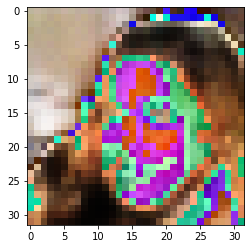

In [57]:
from PIL import Image
a=samples[0][0].cpu()
trans = transforms.ToPILImage()
plt.imshow(trans(a))

In [0]:
from tensorflow import summary
%reload_ext tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
import os
LOG_DIR = 'runs'
os.makedirs(LOG_DIR, exist_ok=True)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d2585eb1.ngrok.io


In [0]:
%tensorboard --logdir runs